In [153]:
import argparse
import pickle
import os
import numpy as np
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import matplotlib as mpl
from sklearn.metrics import mean_squared_error as mse
from scipy import signal
from keras.models import model_from_json
from speech2ult.tools.transform_ultrasound import transform_ultrasound

In [154]:
def load_model(path, ssim=False):
    """load in models from the specified path"""
    model_weights = path[:-10] + 'weights.h5'
    with open(path, "r") as json_file:
        loaded_model_json = json_file.read()
    model = model_from_json(loaded_model_json)
    # load weights into model
    model.load_weights(model_weights)
    if ssim:
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=SSIMLoss)
    else:
        model.compile(loss='mean_squared_error', optimizer='adam')

    return model

def SSIMLoss(y_true, y_pred):
    """https://stackoverflow.com/questions/57357146/use-ssim-loss-function-with-keras"""
    y_true = tf.reshape(y_true, (-1, 64, 128, 1))
    y_pred = tf.reshape(y_pred, (-1, 64, 128, 1))

    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

class TestFile:
    def __init__(self, basename, ult, wav, sr, dlc_ult):
        self.basename = basename
        self.ult = ult
        self.wav = wav
        self.sr = sr
        self.dlc = dlc_ult
        self.aud_scalar = None
        self.ult_scalar = None
        self.dlc_scalar = None
        self.aud_feat = None
        self.window = None
        self.lstm = None
        self.get_butter()
        self.get_med()
        self.get_bothfilt()

    def get_butter(self):
        """apply butterworth filter to each column (body part)"""
        filtered = np.empty_like(self.dlc)
        fc = 10  # Cut-off frequency of the filter
        w = fc / (60 / 2)  # Normalize the frequency
        b, a = signal.butter(5, w, 'low')

        for col in range(self.dlc.shape[1]):
            filtered[:, col] = signal.filtfilt(b, a, self.dlc[:, col])

        self.butter = filtered

    def get_med(self):
        """apply median filter to each column (body part)"""
        filtered = np.empty_like(self.dlc)
        for col in range(self.dlc.shape[1]):
            filtered[:, col] = signal.medfilt(self.dlc[:, col], 7)

        self.medfilt = filtered

    def get_bothfilt(self):
        """apply median filter to each column (body part)"""
        filtered = np.empty_like(self.dlc)
        for col in range(self.dlc.shape[1]):
            filtered[:, col] = signal.medfilt(self.butter[:, col], 7)

        self.bothfilt = filtered

def transfrom(ult, colour=0):
    ult_t = transform_ultrasound(ult, background_colour=colour, num_scanlines=64,
                             size_scanline=128, angle=0.025,
                             zero_offset=30, pixels_per_mm=0.5)

    # get rid of border
    ult_t = ult_t[:, 50:-50, 10:-10]
    return ult_t

def make_vid(img_dir, name, type='avi', out_dir=None):
    if not out_dir:
        out_dir = img_dir
    subprocess.call(
        ["ffmpeg", "-y", "-r", "60",
         "-i", img_dir + "/%07d.jpg", "-vcodec", "mpeg4", "-qscale", "5", "-r",
         "60", out_dir + f"/{name}.{type}"])

In [224]:
dlc_tests = 'speech2ult/predictions/models/dlc_tests'
# choose which dlc test build to use and which trained model to load in
test_name = 'ffn_dlc_med'
model = 'model'

In [225]:
col_names = ['vallecula_x', 'vallecula_y', 'tongueRoot1_x', 'tongueRoot1_y',
       'tongueRoot2_x', 'tongueRoot2_y', 'tongueBody1_x', 'tongueBody1_y',
       'tongueBody2_x', 'tongueBody2_y', 'tongueDorsum1_x', 'tongueDorsum1_y',
       'tongueDorsum2_x', 'tongueDorsum2_y', 'tongueBlade1_x',
       'tongueBlade1_y', 'tongueBlade2_x', 'tongueBlade2_y', 'tongueTip1_x',
       'tongueTip1_y', 'tongueTip2_x', 'tongueTip2_y']

In [226]:
aai_path = glob.glob(os.path.join(dlc_tests, test_name, model, '*.json'))[0]
dlc2ult_path = glob.glob(os.path.join(dlc_tests[:-10], 'dlc2ult', f'model_{names[test_name]}*', '*.json'))[0] # to get model2 use index 1
aud_path = glob.glob(os.path.join(dlc_tests, test_name, 'data', 'AUD*.pickle'))[0]
dlc_path = glob.glob(os.path.join(dlc_tests, test_name, 'data', 'ULT*.pickle'))[0]
ult_path = 'speech2ult/predictions/models/dlc2ult/ult_test_lips.pickle'
dlc_test_clean = 'speech2ult/predictions/models/dlc2ult/fixed_test_scaled.pickle'
ppmm = 3.1625

In [227]:
# load in the models
aai_model = load_model(aai_path)
dlc2ult = load_model(dlc2ult_path, ssim=True)

# load in the data dicts
with open(aud_path, 'rb') as file:
    aud_dict, aud_params = pickle.load(file)

with open(dlc_path, 'rb') as file:
    dlc_dict, dlc_params = pickle.load(file)

with open(dlc_test_clean, 'rb') as file:
    clean_dlc, dlc_scaler = pickle.load(file)

with open(ult_path, 'rb') as file:
    ult_test, ult_params = pickle.load(file)


In [228]:
# predict entire test set with aai-dlc model
dlc_pred = aai_model.predict(aud_dict['test'], verbose=0)
# rescale
pred_scal = dlc_params['scalar'].inverse_transform(dlc_pred)
true_scal = dlc_params['scalar'].inverse_transform(dlc_dict['test'])

In [229]:
# for no filter
true_scal = clean_dlc

In [230]:
rmse = mse(true_scal, pred_scal, squared=False)/ppmm
print(f"rmse in mm is: {rmse} - assuming ppmm: {ppmm}")
# try to get x loss and y loss to see if there is a difference
pred_scal_xy = pred_scal.reshape((-1, 11, 2)).copy()
true_scal_xy = true_scal.reshape((-1, 11, 2)).copy()
rmse_x = mse(true_scal_xy[:,:,0], pred_scal_xy[:,:,0], squared=False)/ppmm
rmse_y = mse(true_scal_xy[:,:,1], pred_scal_xy[:,:,1], squared=False)/ppmm
print(f'rmse in mm for x coordinates: {rmse_x}')
print(f'rmse in mm for y coordinates: {rmse_y}')


# for i in range(len(col_names)):
#     rmse_feat = mse(true_scal[:,i], pred_scal[:,i], squared=False)/ppmm
#     print(f'rmse in mm for {col_names[i]}: {rmse_feat}')



rmse in mm is: 5.188536232561892 - assuming ppmm: 3.1625
rmse in mm for x coordinates: 5.759150430908323
rmse in mm for y coordinates: 4.617922034215457


In [173]:
# try to get rid of some outliers?
print(true_scal_xy[0,1,0], pred_scal_xy[0,1,0])

190.03683471679688 208.64093


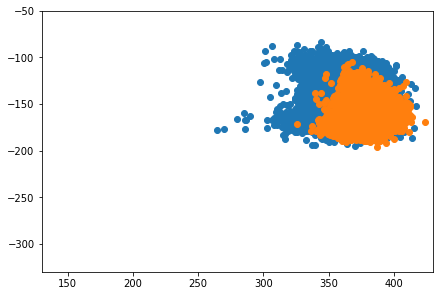

In [146]:
colors = np.array([100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0])
feat = 10
fig, ax = plt.subplots(layout='constrained')
ax.set_xlim([130, 430])
ax.set_ylim([-330, -50])
ax.scatter(true_scal_xy[:, feat, 0], -true_scal_xy[:, feat, 1], cmap='plasma')
ax.scatter(pred_scal_xy[:, feat, 0], -pred_scal_xy[:, feat, 1], cmap='plasma')
plt.show()

In [231]:
# with predicted dlc eval dlc2ult
dlc2ult.evaluate(dlc_pred, ult_test, verbose=2)

529/529 - 270s - loss: 0.0196 - SSIMLoss: 0.8271 - 270s/epoch - 511ms/step


[0.019565997645258904, 0.8270866274833679]

In [ ]:
# prediction on test file holder
pred_list = []
pred_list_names = []

In [155]:
# testfile
testfiles = glob.glob('speech2ult/predictions/test_data/*testfile*')
testfile_path = testfiles[1]

# load in testfile
with open(testfile_path, 'rb') as file:
    testfile = pickle.load(file)

testfile.transform = transfrom(testfile.ult)
testfile.xy = testfile.dlc.reshape((-1, 11, 2))
testfile.both_xy = testfile.bothfilt.reshape((-1, 11, 2))
testfile.med_xy = testfile.medfilt.reshape((-1, 11, 2))
testfile.butter_xy = testfile.butter.reshape((-1, 11, 2))
filter = {
    'both': testfile.bothfilt,
    'butter': testfile.butter,
    'median': testfile.medfilt
}



In [ ]:
# save all in a list to make video together?
test_dlc_pred = aai_model.predict(testfile.aud_feat, verbose=0)
ult_pred = dlc2ult.predict(test_dlc_pred, verbose=0)
pred_list.append(ult_pred)
pred_list_names.append(f'{test_name}_{model}')

In [ ]:
# once i have all the prediction save them

In [174]:
names = {
    'ffn_dlc': 'ffn_dlc',
    'ffn_dlc_both': 'ffn_both',
    'ffn_dlc_butter': 'ffn_butter',
    'ffn_dlc_med': 'ffn_med'
}

In [175]:
test_name='ffn_dlc_both'
dlc2ult_path = glob.glob(os.path.join(dlc_tests[:-10], 'dlc2ult', f'model_{names[test_name]}*', '*.json'))[0]
print(dlc2ult_path)

/Users/jacobrosen/Desktop/Edinburgh/Dissertation/project_code/predictions/models/dlc2ult/model_ffn_both/dlc2ult_lips_test_2022-08-04_model.json
